In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [18]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# EDA

In [2]:
df = pd.read_csv('./data/news_train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [15]:
df_count = df.Category.value_counts().reset_index()

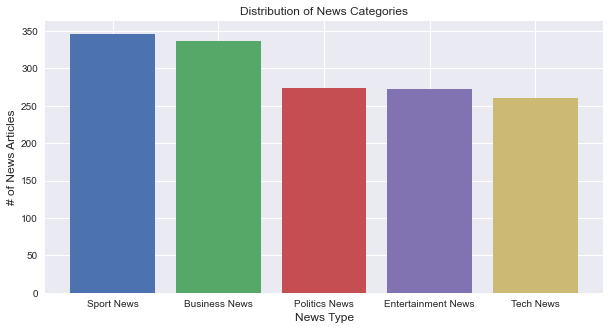

In [14]:
plt.figure(figsize=(10, 5))
plt.bar('Sport News', len(df[df['Category']=='sport']))
plt.bar('Business News', len(df[df['Category']=='business']))
plt.bar('Politics News', len(df[df['Category']=='politics']))
plt.bar('Entertainment News', len(df[df['Category']=='entertainment']))
plt.bar('Tech News', len(df[df['Category']=='tech']))
plt.title('Distribution of News Categories', size=12)
plt.xlabel('News Type', size=12)
plt.ylabel('# of News Articles', size=12);

In [16]:
df['id'] = df['Category'].factorize()[0]
df.drop(['ArticleId'], axis=1, inplace=True)
df.head()

,Text,Category,id
0,worldcom ex-boss launches defence lawyers defe...,business,0
1,german business confidence slides german busin...,business,0
2,bbc poll indicates economic gloom citizens in ...,business,0
3,lifestyle governs mobile choice faster bett...,tech,1
4,enron bosses in $168m payout eighteen former e...,business,0


business related words:


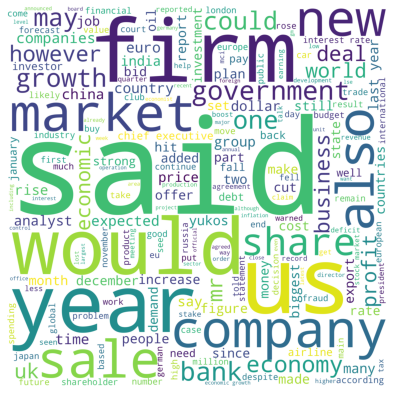

tech related words:


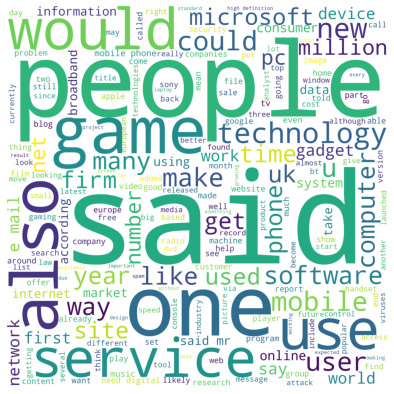

politics related words:


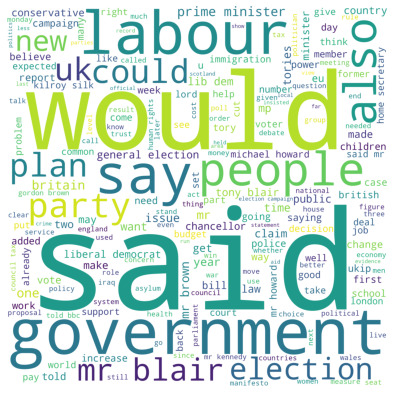

sport related words:


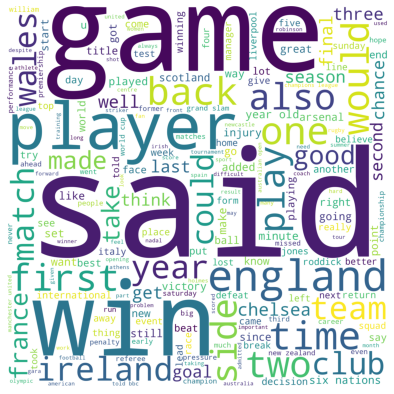

entertainment related words:


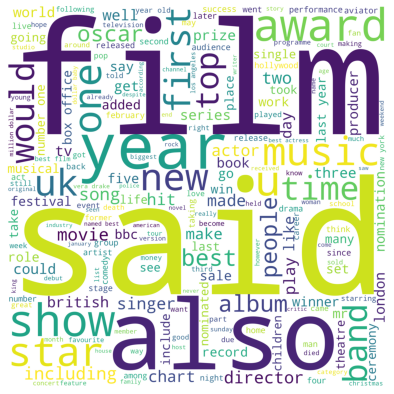

In [24]:
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

business = df[df['id'] == 0]
business = business['Text']

tech = df[df['id'] == 1]
tech = tech['Text']

politics = df[df['id'] == 2]
politics = politics['Text']

sport = df[df['id'] == 3]
sport = sport['Text']

entertainment = df[df['id'] == 4]
entertainment = entertainment['Text']


def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

print("business related words:")
wordcloud_draw(business, 'white')

print("tech related words:")
wordcloud_draw(tech, 'white')

print("politics related words:")
wordcloud_draw(politics, 'white')

print("sport related words:")
wordcloud_draw(sport, 'white')

print("entertainment related words:")
wordcloud_draw(entertainment, 'white')

# Data Cleaning

In [26]:
def preprocessor(text):

    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

df['Text'] = df['Text'].apply(preprocessor)

In [27]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]

df['Text'] = df['Text'].apply(remove_stopwords)

In [28]:
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

df['Text'] = df['Text'].apply(lemmatize_word)

In [29]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [30]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(df['Text'])
y = df['id'].values

## Build a classification model using various methods

In [45]:
model_params = {

    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['newton-cg', 'liblinear']
        }
    },

    'kneighbours': {
        'model': KNeighborsClassifier(n_jobs=-1),
        "params": {
            
            'n_neighbors' : [10, 50, 100],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(n_jobs=-1),
        'params' : {
            'n_estimators': [1,5,10,100],
            'max_depth': [2,3,4,5],
            'min_samples_leaf': [100,200,300,500,1000],
            'criterion' : ['gini','entropy'], 
        }
    },
    'xgboost':{'model':XGBClassifier(n_jobs=-1), 
              'params':{
              'n_estimators': [100, 150],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [4, 5, 6],              
                  }
              },

}

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_.round(4),
        'best_params': clf.best_params_
    })

logistic_regression
kneighbours


/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

random_forest


/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

xgboost


In [47]:
rel = pd.DataFrame(scores,columns=['model','best_score','best_params'])
rel.sort_values('best_score', ascending=False)

,model,best_score,best_params
0,logistic_regression,0.9745,"{'C': 10, 'solver': 'liblinear'}"
1,kneighbours,0.9477,{'n_neighbors': 50}
3,xgboost,0.9436,"{'learning_rate': 1, 'max_depth': 5, 'n_estima..."
2,random_forest,0.4403,"{'criterion': 'entropy', 'max_depth': 5, 'min_..."


The results from the table tells us that we should use logistic regression with the following best parameters.

## Using the best model as baseline

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [50]:
model = LogisticRegression(multi_class='auto', C=10, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [51]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.9630872483221476
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        67
           1       0.96      0.98      0.97        52
           2       0.93      0.96      0.95        55
           3       1.00      0.99      0.99        69
           4       0.98      0.98      0.98        55

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



Text(0.5, 1.0, 'Confusion Matrix')

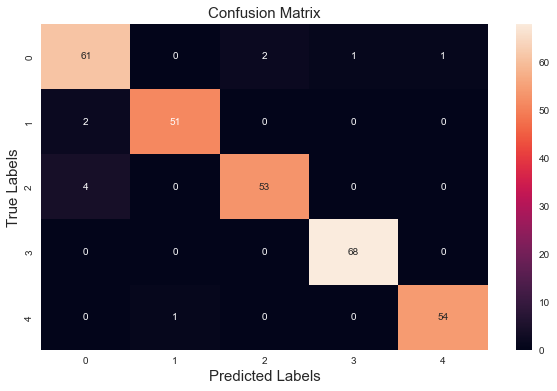

In [52]:
import seaborn as sns

matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
# ax.xaxis.set_ticklabels([0,1], size=15)
# ax.yaxis.set_ticklabels([0,1], size=15);

# Keras

In [53]:
import tensorflow as tf

In [55]:
X = df['Text']
y = df['id']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [57]:
import re

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [58]:
vocab_size = 5000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [60]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [61]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [62]:
input_dim = X_train.shape[1]

## Dense

### Simple

In [106]:
model = tf.keras.models.Sequential([

tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(embedding_dim, activation='relu'),
tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 5)                 325       
                                                                 
Total params: 41,477
Trainable params: 41,477
Non-trainable params: 0
_________________________________________________________________


In [107]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall')
# ]
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
34/34 [==============================] - 1s 8ms/step - loss: 673.9347 - accuracy: 0.2189 - val_loss: 404.5192 - val_accuracy: 0.1696
Epoch 2/10
34/34 [==============================] - 0s 3ms/step - loss: 290.9702 - accuracy: 0.2935 - val_loss: 200.0753 - val_accuracy: 0.1875
Epoch 3/10
34/34 [==============================] - 0s 3ms/step - loss: 179.1297 - accuracy: 0.3224 - val_loss: 169.1963 - val_accuracy: 0.1964
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 129.6498 - accuracy: 0.3333 - val_loss: 139.5530 - val_accuracy: 0.2500
Epoch 5/10
34/34 [==============================] - 0s 3ms/step - loss: 96.5959 - accuracy: 0.4050 - val_loss: 122.9894 - val_accuracy: 0.2411
Epoch 6/10
34/34 [==============================] - 0s 3ms/step - loss: 73.2090 - accuracy: 0.4448 - val_loss: 115.0503 - val_accuracy: 0.2768
Epoch 7/10
34/34 [==============================] - 0s 3ms/step - loss: 65.0726 - accuracy: 0.4736 - val_loss: 92.8138 - val_accuracy: 0.3

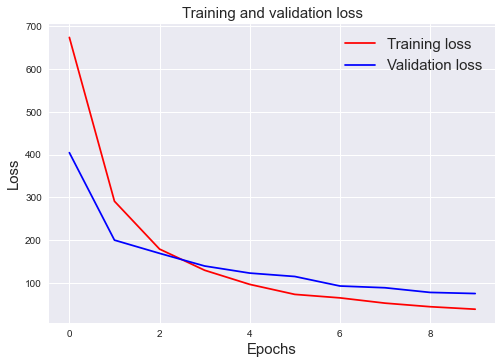

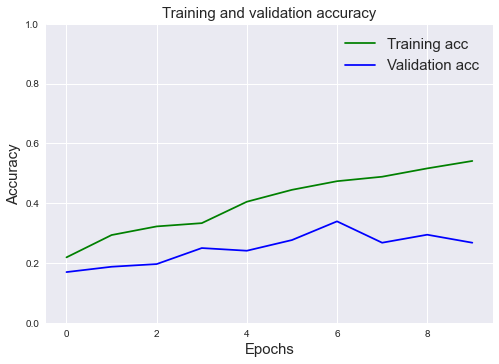

In [109]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0,1))
plt.show()

In [110]:
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# pred = model.predict(X_test)

# # binary_predictions = []

# # for i in pred:
# #     if i >= 0.5:
# #         binary_predictions.append(1)
# #     else:
# #         binary_predictions.append(0)

# print("---Test Set Results---")
# print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
# print(classification_report(y_test, binary_predictions))

In [111]:
# import seaborn as sns


# matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
# plt.figure(figsize=(10, 6))
# ax= plt.subplot()
# sns.heatmap(matrix, annot=True, ax = ax)

# # labels, title and ticks
# ax.set_xlabel('Predicted Labels', size=15)
# ax.set_ylabel('True Labels', size=15)
# ax.set_title('Confusion Matrix', size=15)
# ax.xaxis.set_ticklabels([0,1], size=15)
# ax.yaxis.set_ticklabels([0,1], size=15);

### Embedding

In [112]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           320000    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_22 (Dense)            (None, 128)               2097280   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 2,417,925
Trainable params: 2,417,925
Non-trainable params: 0
_________________________________________________________________


In [115]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [116]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
34/34 [==============================] - 1s 19ms/step - loss: 1.4824 - accuracy: 0.3552 - val_loss: 1.3989 - val_accuracy: 0.4286
Epoch 2/10
34/34 [==============================] - 1s 16ms/step - loss: 0.6483 - accuracy: 0.8706 - val_loss: 0.7275 - val_accuracy: 0.7857
Epoch 3/10
34/34 [==============================] - 1s 16ms/step - loss: 0.0716 - accuracy: 0.9960 - val_loss: 0.4239 - val_accuracy: 0.8661
Epoch 4/10
34/34 [==============================] - 1s 18ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.9018
Epoch 5/10
34/34 [==============================] - 1s 17ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3251 - val_accuracy: 0.9107
Epoch 6/10
34/34 [==============================] - 1s 16ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3361 - val_accuracy: 0.9107
Epoch 7/10
34/34 [==============================] - 1s 17ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3155 - val_accuracy: 0.9107
Epoch 8/10
34

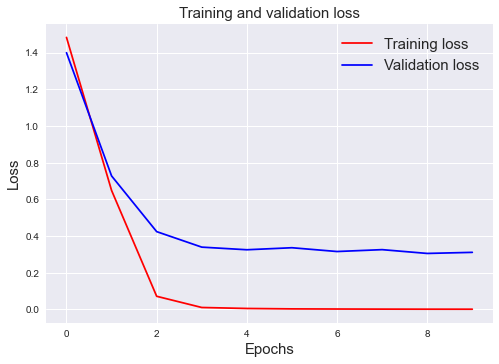

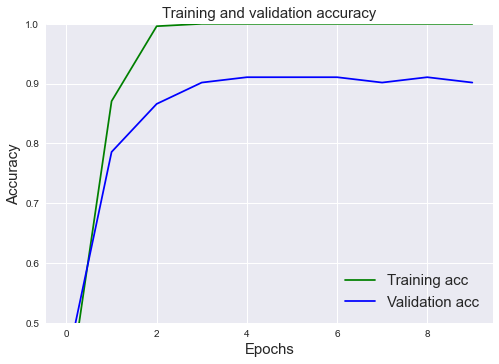

In [117]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

## LSTM

In [118]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 64)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 5)                 325       
                                                                 
Total params: 427,589
Trainable params: 427,589
Non-tr

In [119]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
34/34 [==============================] - 18s 339ms/step - loss: 1.5618 - accuracy: 0.3005 - val_loss: 1.2109 - val_accuracy: 0.4732
Epoch 2/10
34/34 [==============================] - 10s 284ms/step - loss: 0.9523 - accuracy: 0.6856 - val_loss: 0.6973 - val_accuracy: 0.8125
Epoch 3/10
34/34 [==============================] - 10s 290ms/step - loss: 0.3555 - accuracy: 0.9333 - val_loss: 0.3887 - val_accuracy: 0.8839
Epoch 4/10
34/34 [==============================] - 9s 267ms/step - loss: 0.2118 - accuracy: 0.9493 - val_loss: 0.4080 - val_accuracy: 0.9018
Epoch 5/10
34/34 [==============================] - 10s 307ms/step - loss: 0.1098 - accuracy: 0.9791 - val_loss: 0.3248 - val_accuracy: 0.9107
Epoch 6/10
34/34 [==============================] - 10s 279ms/step - loss: 0.0594 - accuracy: 0.9910 - val_loss: 0.3233 - val_accuracy: 0.9018
Epoch 7/10
34/34 [==============================] - 10s 295ms/step - loss: 0.0307 - accuracy: 0.9980 - val_loss: 0.3792 - val_accuracy: 0.9107


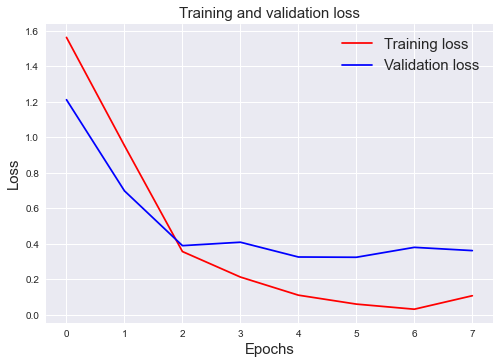

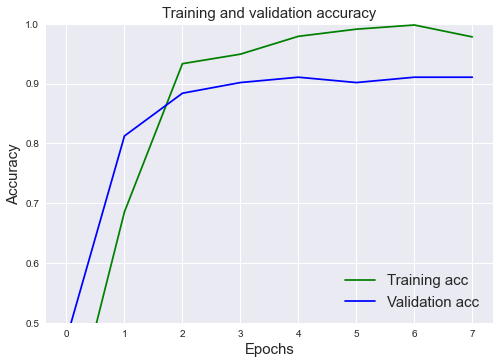

In [121]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

This model has the same results as the dense model with embedding, but a longer run time. 